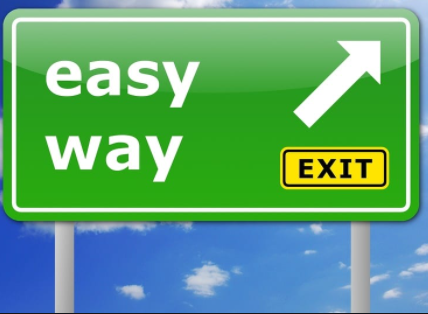

The first step in kaggle is to get better results in an easy way.

Kaggleの第一歩は楽は方法でより良い結果をえることが重要です。

LightGBMTunerCV　is a very good tool because everything(LGBM + CV + Quickly optimisation) is one package.

LightGBMTunerCVは全てが一つのパッケージとなりとても良いツールの一つです。

I recommend that you use this Easy-Way study for your next　deep exploration.

この方法を使って次の深い探索をすることをお勧めします。

Don't forget to vote !!

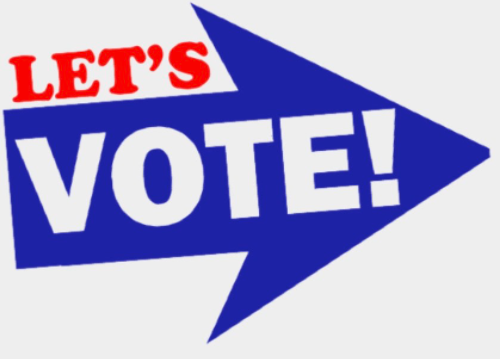

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Reading files from directory
import os
import pickle
 
# Data manipulation & analysis
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 500)
import datetime as dt
 
import numpy as np
import scipy

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
 
 # 実行に関係ない警告を無視
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import gc
import json
import math

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score,roc_auc_score


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

from lightgbm import LGBMClassifier
import lightgbm


In [ ]:
#実行環境がどこの階層にあるか、パスを検索
import os
print(os.getcwd())

In [ ]:
train = pd.read_csv("../input/tabular-playground-series-apr-2021/train.csv")
test = pd.read_csv("../input/tabular-playground-series-apr-2021/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-apr-2021/sample_submission.csv")

In [ ]:
display(train.head())
display(train.describe())
display(train.info())

In [ ]:
train.columns

In [ ]:
#--------------------------------
#数値の特徴量　※上級者は、特徴量のリストを作成している。
#------------------------------
features_num = ['Age', 'Fare','SibSp','Parch', 'Pclass',]
features_cat = ['Sex','Embarked' ] 
features_str = ['Name','Ticket','Cabin']
features_all = features_num + features_cat + features_str

# Update numeric cols as float
train[features_num] = train[features_num].astype(np.float64)
test[features_num] = test[features_num].astype(np.float64)

# Update categorical cols as categories
train[features_cat] = train[features_cat].astype('category')
test[features_cat] = test[features_cat].astype('category')


In [ ]:
#相関係数を定義
corr_pearson = train[features_all].corr(method='pearson')
corr_spearman =train[features_num].corr(method='spearman')

In [ ]:
fig = plt.figure(figsize = (12,9))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=+1, fmt="1.1f")
plt.title('Pearson Correlation')
plt.show()

In [ ]:
#特徴量作成のためにデータを結合
df_data = pd.concat([train, test], sort=False)
df_data

In [ ]:
#complete sex with mode
df_data['Sex'].fillna(df_data['Sex'].mode()[0], inplace = True)


# Age fillna with mean age for each class
df_data['Age'] = df_data['Age'].fillna(df_data['Age'].mean())

# Cabin, fillna with 'X' and take first letter 先頭文字にする　NaNはXとする
df_data['Cabin'] = df_data['Cabin'].fillna('X').map(lambda x: x[0].strip())

# Ticket, fillna with 'X', split string and take first split   先頭文字にする　NaNはXとする
df_data['Ticket'] = df_data['Ticket'].fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

# Fare, fillna with mean value
fare_map = df_data[['Fare', 'Pclass']].dropna().groupby('Pclass').median().to_dict()
df_data['Fare'] = df_data['Fare'].fillna(df_data['Pclass'].map(fare_map['Fare']))
df_data['Fare'] = np.log1p(df_data['Fare'])

# Embarked, fillna with 'X' value

df_data['Embarked'].fillna(df_data['Embarked'].mode()[0], inplace = True)##最頻値

# Name, take only surnames 　NaNはXとする
df_data['Name'] = df_data['Name'].map(lambda x: x.split(',')[0])

In [ ]:

##--------------------------------------------
#カテゴリfeature  　ラベルエンコーダー
#---------------------------------------------
for feature in features_str :
    le = LabelEncoder()
    le.fit(df_data[feature])
    df_data[feature] = le.transform(df_data[feature])


##--------------------------------------------
#カテゴリfeature  　one-hotエンコーダー
#---------------------------------------------

df_data = pd.get_dummies(df_data, columns= features_cat )


##--------------------------------------------
#標準化スケーラー
#---------------------------------------------

sc = StandardScaler()
df_data[features_num] = sc.fit_transform(df_data[features_num])

In [ ]:
#特徴量作成後に、train_x  , test_x 元にデータ形状に戻す
#df_dataをdf_trainの長さで切り、それ以降でデータを分ける
 
train = df_data[:len(train)]
test = df_data[len(train):]

In [ ]:
# 学習データを特徴量と目的変数に分ける  正解ラべルを記入
train_x = train.drop(['Survived'], axis=1)
train_y = train['Survived']
 
# 特徴量で結合して演算していると正解ラベルにNaNが入ることがあるので削除する
#test_x = test
test_x = test.drop(['Survived'], axis=1)

In [ ]:
# 変数PassengerIdを除外する
train_x = train_x.drop(['PassengerId'], axis=1)
test_x = test_x.drop(['PassengerId',], axis=1)


In [ ]:
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import train_test_split

def build():

    # データセットの分割方法
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # LightGBM用のデータセットに変換
    dtrain = lgb.Dataset(train_x, label=train_y)


    # ハイパーパラメータサーチ&モデル構築
    params =  {'objective': 'binary',
              'metric':'binary_logloss',
              'random_seed':71,
              } 

    # クロスバリデーションによるハイパーパラメータの探索 5fold
    best_params = {}
    tuner = lgb.LightGBMTunerCV(params, dtrain,
                                verbose_eval=False, 
                                num_boost_round=10000,
                                early_stopping_rounds=100, 
                                folds=folds,
                               )


    # ハイパーパラメータ探索の実行
    tuner.run()

    # サーチしたパラメータの表示
    best_score = tuner.best_score
    best_params = tuner.best_params
    
    print("  Params: ")
    for key, value in best_params.items():
        print("   {}: {}".format(key, value))

    return tuner
tuner = build()

In [ ]:
##############################
#######     LGBMClassifier by tunner
################################

train_oof_lgbm_0 = np.zeros((train_x.shape[0],))
test_preds_lgbm_0 = 0

lgbm_params= tuner.best_params
#lgbm_params={
#    'objective': 'binary',
 #   'metric': 'binary_logloss',
  #  'random_seed': 71,
   # 'feature_pre_filter': False,
    #'lambda_l1': 8.365958995688352,
#    'lambda_l2': 0.03664386468415251,
 #   'num_leaves': 31,
  #  'feature_fraction': 0.6,
   # 'bagging_fraction': 1.0,
#    'bagging_freq': 0,
 #   'min_child_samples': 20,}


NUM_FOLDS = 5
kf =  StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=137)

evaluation_results = {}  
for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train_x, train_y))):
        print(f'Fold {f+1}')
        train_df, val_df = train_x.iloc[train_ind], train_x.iloc[val_ind]
        train_target, val_target = train_y.iloc[train_ind], train_y.iloc[val_ind]
                
        model = LGBMClassifier(**lgbm_params)


        model =  model.fit(train_df, train_target,
                           eval_set=[(val_df,val_target)],
                           early_stopping_rounds=200,verbose="false" )
        temp_oof = model.predict_proba(val_df)[:,1]
        temp_test = model.predict_proba(test_x)[:,1]

        train_oof_lgbm_0[val_ind] = temp_oof
        test_preds_lgbm_0 += temp_test/NUM_FOLDS
        
        print(roc_auc_score(val_target, temp_oof))
        
print(roc_auc_score(train_y, train_oof_lgbm_0))
np.save('train_oof_lgbm_0', train_oof_lgbm_0 ) #for validation
np.save('test_preds_lgbm_0',test_preds_lgbm_0 ) #for submission


In [ ]:
pred_label = test_preds_lgbm_0
pred_label = np.where(pred_label>0.5, 1, 0)
pred_label

In [ ]:
##### 提出用ファイルの作成 ヘッダー無設の設定
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': pred_label})
submission.to_csv('submission_test.csv', index=False)

display(submission.head(), submission.tail())

In [ ]:
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# importanceを表示する
plt.rcParams["figure.figsize"] = (10, 5)
lightgbm.plot_importance(model,max_num_features = 25,height=.8)